# Nuclear Stance Classification Results

Visualizes output from `classify_initiative_and_feedback.py`.

In [1]:
import json
import os
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 120)
plt.rcParams["figure.dpi"] = 120

In [2]:
# --- CONFIGURE ---
INPUT_DIR = "classification_results_v4/"  # output dir from classify_initiative_and_feedback.py
# -----------------

## Load data

In [3]:
initiatives = []
feedback_rows = []

for fname in sorted(os.listdir(INPUT_DIR)):
    if not fname.endswith(".json") or fname.startswith("_"):
        continue
    with open(os.path.join(INPUT_DIR, fname), encoding="utf-8") as f:
        d = json.load(f)

    # Normalize stance fields — could be a single value or list (multi-run)
    def get_stance(val):
        if isinstance(val, list):
            return val  # multi-run
        return [val] if val is not None else []

    row = {
        "id": d["id"],
        "short_title": d.get("short_title", ""),
        "type_of_act": d.get("type_of_act", ""),
        "department": d.get("department", ""),
        "topics": ", ".join(d.get("topics", [])),
        "policy_areas": ", ".join(d.get("policy_areas", [])),
        "published_date": d.get("published_date", ""),
        "n_feedback": len(d.get("middle_feedback", [])),
        "before_stance": get_stance(d.get("before_feedback_nuclear_stance")),
        "after_stance": get_stance(d.get("after_feedback_nuclear_stance")),
        "before_complex": get_stance(d.get("before_feedback_nuclear_stance_complex")),
        "after_complex": get_stance(d.get("after_feedback_nuclear_stance_complex")),
    }
    initiatives.append(row)

    for fb in d.get("middle_feedback", []):
        fb_stance = get_stance(fb.get("nuclear_stance"))
        if fb_stance:
            feedback_rows.append({
                "initiative_id": d["id"],
                "short_title": d.get("short_title", ""),
                "feedback_id": fb.get("id"),
                "user_type": fb.get("user_type", ""),
                "country": fb.get("country", ""),
                "organization": fb.get("organization", ""),
                "stance": fb_stance,
            })

df_init = pd.DataFrame(initiatives)
df_fb = pd.DataFrame(feedback_rows)

# Detect number of runs
n_runs = max(len(df_init["before_stance"].iloc[0]), 1) if len(df_init) else 1

print(f"Loaded {len(df_init)} initiatives, {len(df_fb)} feedback items")
print(f"Runs per prompt: {n_runs}")

Loaded 118 initiatives, 77978 feedback items
Runs per prompt: 16


## Helpers

In [4]:
LABEL_ORDER = ["SUPPORT", "NEUTRAL", "OPPOSE", "DOES NOT MENTION"]
LABEL_COLORS = {
    "SUPPORT": "#2ecc71",
    "NEUTRAL": "#f39c12",
    "OPPOSE": "#e74c3c",
    "DOES NOT MENTION": "#95a5a6",
}


def majority(labels):
    """Return majority label from a list; None if empty."""
    if not labels:
        return None
    c = Counter(labels)
    return c.most_common(1)[0][0]


def label_fractions(labels):
    """Return dict of label -> fraction of runs for that label."""
    if not labels:
        return {l: 0.0 for l in LABEL_ORDER}
    c = Counter(labels)
    n = len(labels)
    return {l: c.get(l, 0) / n for l in LABEL_ORDER}


def add_fraction_columns(df, stance_col, prefix):
    """Add per-label fraction columns to df from a stance list column."""
    fracs = df[stance_col].apply(label_fractions)
    for label in LABEL_ORDER:
        df[f"{prefix}_{label}"] = fracs.apply(lambda d: d[label])
    return [f"{prefix}_{l}" for l in LABEL_ORDER]

## 1. Initiative-level: Simple stance distribution

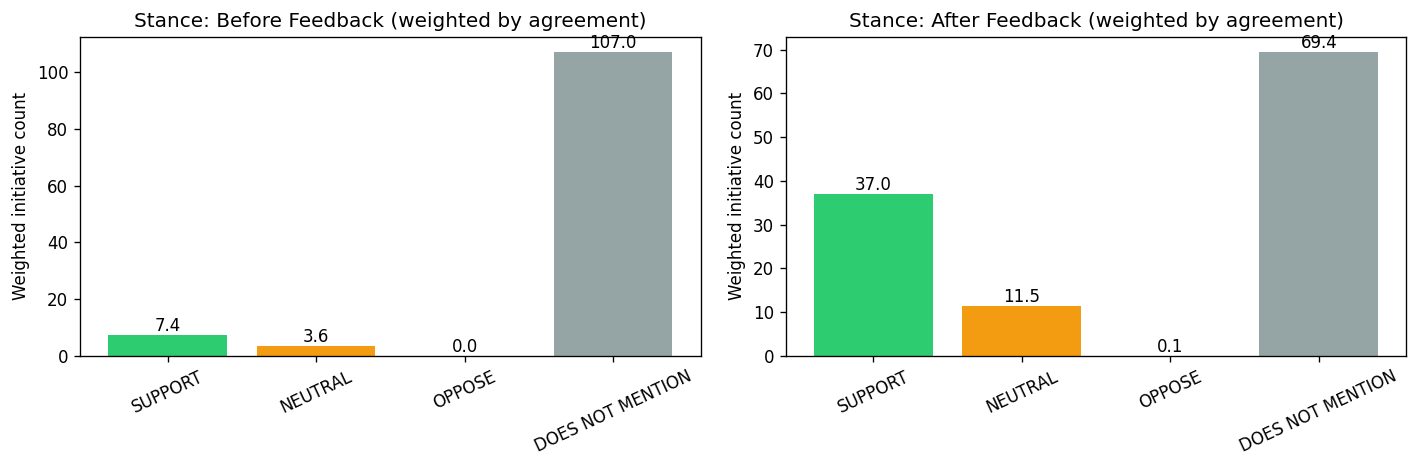

In [5]:
df_init["before_majority"] = df_init["before_stance"].apply(majority)
df_init["after_majority"] = df_init["after_stance"].apply(majority)
before_frac_cols = add_fraction_columns(df_init, "before_stance", "bf")
after_frac_cols = add_fraction_columns(df_init, "after_stance", "af")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, frac_cols, title in [
    (axes[0], before_frac_cols, "Before Feedback"),
    (axes[1], after_frac_cols, "After Feedback"),
]:
    # Weighted counts: sum of per-label fractions across initiatives
    weighted = df_init[frac_cols].sum()
    weighted.index = LABEL_ORDER
    colors = [LABEL_COLORS[l] for l in LABEL_ORDER]
    bars = ax.bar(LABEL_ORDER, weighted.values, color=colors)
    ax.bar_label(bars, fmt="%.1f")
    ax.set_title(f"Stance: {title} (weighted by agreement)")
    ax.set_ylabel("Weighted initiative count")
    ax.tick_params(axis="x", rotation=25)

fig.tight_layout()
plt.show()

## 2. Before vs After comparison (simple)

118 initiatives have both before and after classifications



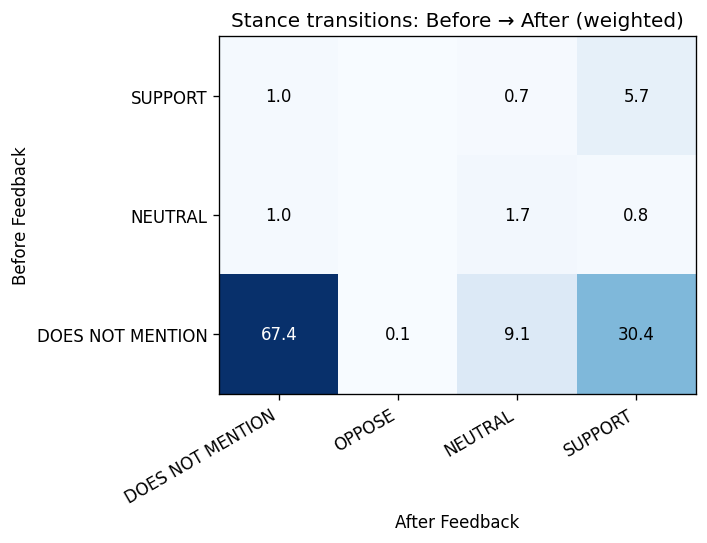


42 initiatives changed majority stance:


,id,short_title,before_majority,after_majority
0,12154,Europe’s Beating Cancer Plan,DOES NOT MENTION,SUPPORT
1,12227,Revision of the Energy Tax Directive,DOES NOT MENTION,NEUTRAL
2,12265,2030 Climate Target Plan,DOES NOT MENTION,SUPPORT
3,12302,Climate change mitigation and adaptation taxonomy,DOES NOT MENTION,SUPPORT
4,12303,ReFuelEU Aviation - Sustainable Aviation Fuels,DOES NOT MENTION,NEUTRAL
5,12306,EU rules on industrial emissions - revision,DOES NOT MENTION,SUPPORT
6,12381,EU Strategy on Adaptation to Climate Change,DOES NOT MENTION,SUPPORT
7,12382,Revision of the guidelines for trans-European Energy infrastructure,DOES NOT MENTION,SUPPORT
8,12383,Strategy for smart sector integration,DOES NOT MENTION,SUPPORT
9,12400,Fitness Check of the EU legislation on animal welfare,DOES NOT MENTION,NEUTRAL


In [6]:
has_both = df_init.dropna(subset=["before_majority", "after_majority"])
print(f"{len(has_both)} initiatives have both before and after classifications\n")

# Continuous transition matrix: each initiative contributes
# before_frac[i] * after_frac[j] to cell (i, j)
trans_matrix = np.zeros((len(LABEL_ORDER), len(LABEL_ORDER)))
for _, r in has_both.iterrows():
    bf = label_fractions(r["before_stance"])
    af = label_fractions(r["after_stance"])
    for i, bl in enumerate(LABEL_ORDER):
        for j, al in enumerate(LABEL_ORDER[::-1]):
            trans_matrix[i, j] += bf[bl] * af[al]

# Drop empty rows/cols
row_mask = trans_matrix.sum(axis=1) > 0
col_mask = trans_matrix.sum(axis=0) > 0
row_labels = [l for l, m in zip(LABEL_ORDER, row_mask) if m]
col_labels = [l for l, m in zip(LABEL_ORDER[::-1], col_mask) if m]
trans_show = trans_matrix[np.ix_(row_mask, col_mask)]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(trans_show, cmap="Blues")
ax.set_xticks(range(len(col_labels)))
ax.set_xticklabels(col_labels, rotation=30, ha="right")
ax.set_yticks(range(len(row_labels)))
ax.set_yticklabels(row_labels)
ax.set_xlabel("After Feedback")
ax.set_ylabel("Before Feedback")
ax.set_title("Stance transitions: Before → After (weighted)")
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        v = trans_show[i, j]
        if v > 0.05:
            ax.text(j, i, f"{v:.1f}", ha="center", va="center",
                    color="white" if v > trans_show.max() / 2 else "black")
fig.tight_layout()
plt.show()

# List initiatives that changed stance (majority-based for readability)
changed = has_both[has_both["before_majority"] != has_both["after_majority"]]
if len(changed):
    print(f"\n{len(changed)} initiatives changed majority stance:")
    display(changed[["id", "short_title", "before_majority", "after_majority"]].reset_index(drop=True))
else:
    print("No initiatives changed majority stance between before and after.")

## 3. Multi-run label fraction distributions (if runs > 1)

In [ ]:
if n_runs > 1:
    # Per-initiative stacked bars showing label fraction breakdown
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, frac_cols, stance_col, title in [
        (axes[0], before_frac_cols, "before_stance", "Before Feedback"),
        (axes[1], after_frac_cols, "after_stance", "After Feedback"),
    ]:
        plot_df = df_init[df_init[stance_col].apply(len) > 0].copy()
        if not len(plot_df):
            ax.set_title(f"{title}: no data")
            continue

        # Sort by SUPPORT fraction descending
        plot_df = plot_df.sort_values(f"{frac_cols[0]}", ascending=True)
        y = np.arange(len(plot_df))
        left = np.zeros(len(plot_df))
        for label, col in zip(LABEL_ORDER, frac_cols):
            vals = plot_df[col].values
            ax.barh(y, vals, left=left, color=LABEL_COLORS[label], label=label)
            left += vals
        ax.set_yticks(y)
        ax.set_yticklabels(
            [f"{r['id']}" for _, r in plot_df.iterrows()],
            fontsize=7,
        )
        ax.set_xlim(0, 1)
        ax.set_xlabel("Fraction of runs")
        ax.set_title(title)
        ax.legend(loc="lower right", fontsize=7)

    fig.suptitle("Per-initiative label fractions across runs", fontsize=12, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # Same chart sorted by initiative ID
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, frac_cols, stance_col, title in [
        (axes[0], before_frac_cols, "before_stance", "Before Feedback"),
        (axes[1], after_frac_cols, "after_stance", "After Feedback"),
    ]:
        plot_df = df_init[df_init[stance_col].apply(len) > 0].copy()
        if not len(plot_df):
            ax.set_title(f"{title}: no data")
            continue

        # Sort by initiative ID
        plot_df = plot_df.sort_values("id", ascending=False)
        y = np.arange(len(plot_df))
        left = np.zeros(len(plot_df))
        for label, col in zip(LABEL_ORDER, frac_cols):
            vals = plot_df[col].values
            ax.barh(y, vals, left=left, color=LABEL_COLORS[label], label=label)
            left += vals
        ax.set_yticks(y)
        ax.set_yticklabels(
            [f"{r['id']}" for _, r in plot_df.iterrows()],
            fontsize=7,
        )
        ax.set_xlim(0, 1)
        ax.set_xlabel("Fraction of runs")
        ax.set_title(title)
        ax.legend(loc="lower right", fontsize=7)

    fig.suptitle("Per-initiative label fractions across runs (sorted by ID)", fontsize=12, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # Scatter: before fraction vs after fraction for each label
    fig, axes = plt.subplots(2, 2, figsize=(10, 9))
    for ax, label in zip(axes.flat, LABEL_ORDER):
        bf_col = f"bf_{label}"
        af_col = f"af_{label}"
        valid = df_init[(df_init["before_stance"].apply(len) > 0) &
                        (df_init["after_stance"].apply(len) > 0)]
        if not len(valid):
            continue
        ax.scatter(valid[bf_col], valid[af_col], alpha=0.5, color=LABEL_COLORS[label], s=30)
        ax.plot([0, 1], [0, 1], "k--", alpha=0.3, lw=1)
        ax.set_xlabel(f"Before fraction")
        ax.set_ylabel(f"After fraction")
        ax.set_title(label)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_aspect("equal")
    fig.suptitle("Before vs After: per-label fraction", fontsize=12, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # Table of most uncertain initiatives (lowest max fraction)
    df_init["before_max_frac"] = df_init[before_frac_cols].max(axis=1)
    df_init["after_max_frac"] = df_init[after_frac_cols].max(axis=1)
    df_init["min_certainty"] = df_init[["before_max_frac", "after_max_frac"]].min(axis=1)
    uncertain = df_init[df_init["min_certainty"] < 1.0].sort_values("min_certainty")
    if len(uncertain):
        print(f"{len(uncertain)} initiatives with < 100% agreement:")
        show = uncertain[["id", "short_title", "before_stance", "before_max_frac",
                          "after_stance", "after_max_frac"]].reset_index(drop=True)
        display(show)
    else:
        print("All initiatives have 100% agreement across runs.")
else:
    print("Single run — skip multi-run analysis.")

## 4. Feedback-level stance distribution

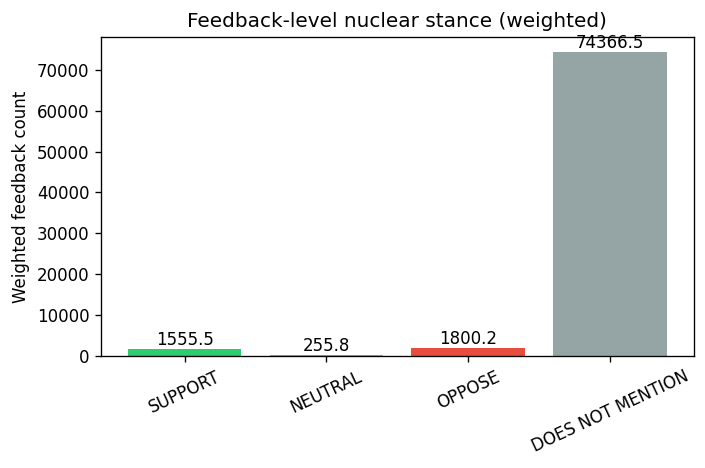

In [8]:
if len(df_fb):
    df_fb["stance_majority"] = df_fb["stance"].apply(majority)
    fb_frac_cols = add_fraction_columns(df_fb, "stance", "fb")

    weighted = df_fb[fb_frac_cols].sum()
    weighted.index = LABEL_ORDER
    colors = [LABEL_COLORS[l] for l in LABEL_ORDER]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(LABEL_ORDER, weighted.values, color=colors)
    ax.bar_label(bars, fmt="%.1f")
    ax.set_title("Feedback-level nuclear stance (weighted)")
    ax.set_ylabel("Weighted feedback count")
    ax.tick_params(axis="x", rotation=25)
    fig.tight_layout()
    plt.show()
else:
    print("No feedback classifications found.")

## 5. Feedback stance by user type

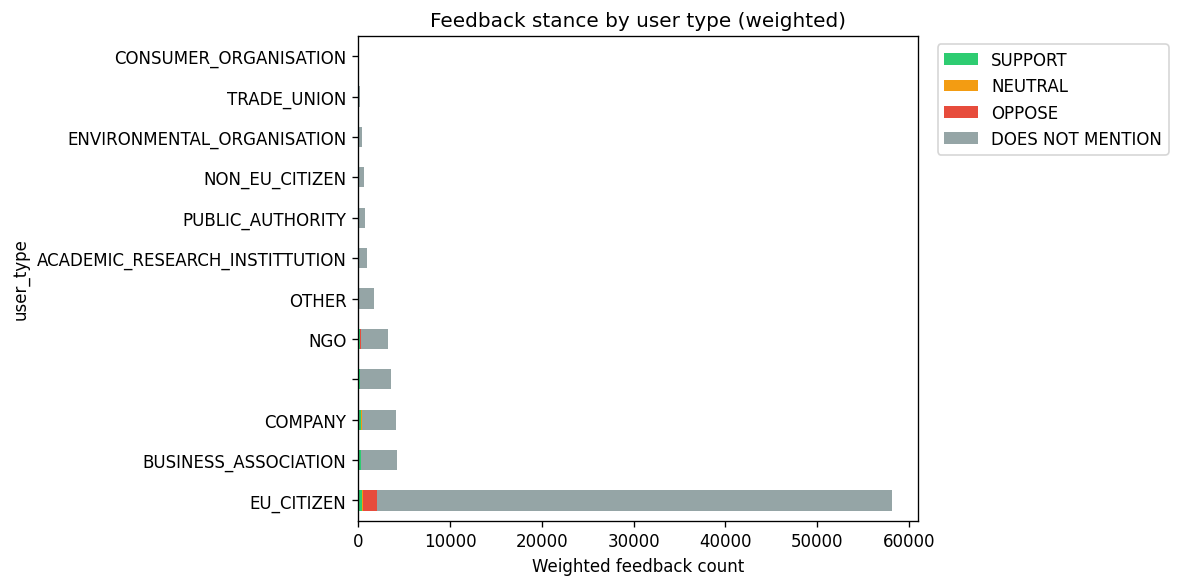

In [9]:
if len(df_fb):
    ct = df_fb.groupby("user_type")[fb_frac_cols].sum()
    ct.columns = LABEL_ORDER
    ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(10, 5))
    ct.plot.barh(
        stacked=True, ax=ax,
        color=[LABEL_COLORS[l] for l in ct.columns],
    )
    ax.set_xlabel("Weighted feedback count")
    ax.set_title("Feedback stance by user type (weighted)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    plt.show()

## 6. Feedback stance by country (top 15)

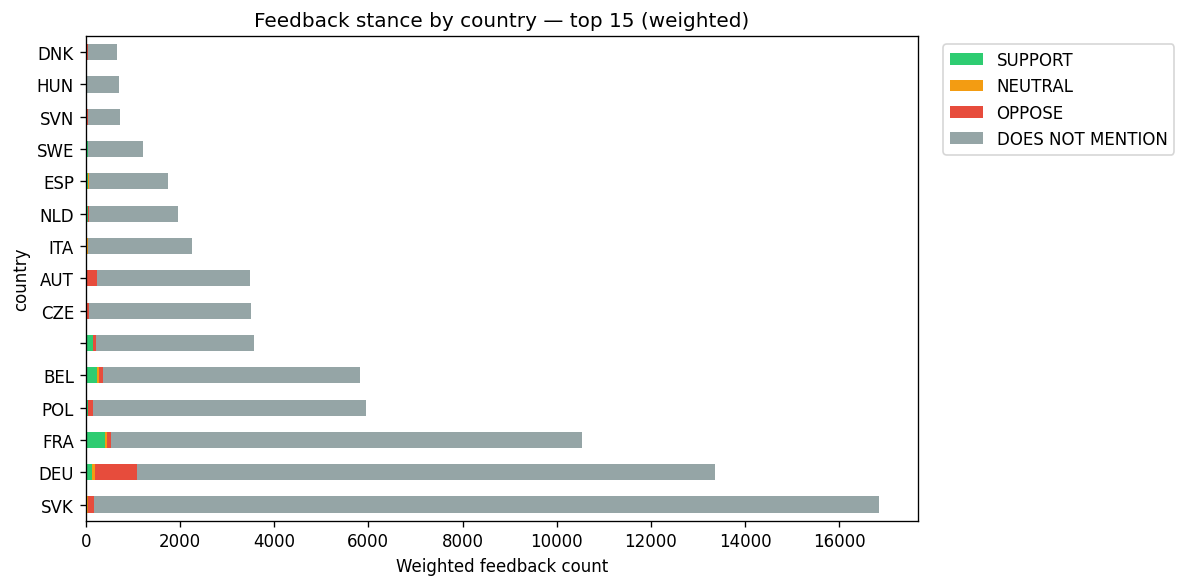

In [10]:
if len(df_fb) and "country" in df_fb.columns:
    top_countries = df_fb["country"].value_counts().head(15).index
    sub = df_fb[df_fb["country"].isin(top_countries)]
    ct = sub.groupby("country")[fb_frac_cols].sum()
    ct.columns = LABEL_ORDER
    ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(10, 5))
    ct.plot.barh(
        stacked=True, ax=ax,
        color=[LABEL_COLORS[l] for l in ct.columns],
    )
    ax.set_xlabel("Weighted feedback count")
    ax.set_title("Feedback stance by country — top 15 (weighted)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    plt.show()

## 7. Per-initiative feedback breakdown

/var/folders/gx/m4r_gc751jq23rrrjzcrs5xr0000gn/T/ipykernel_87173/1704708707.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


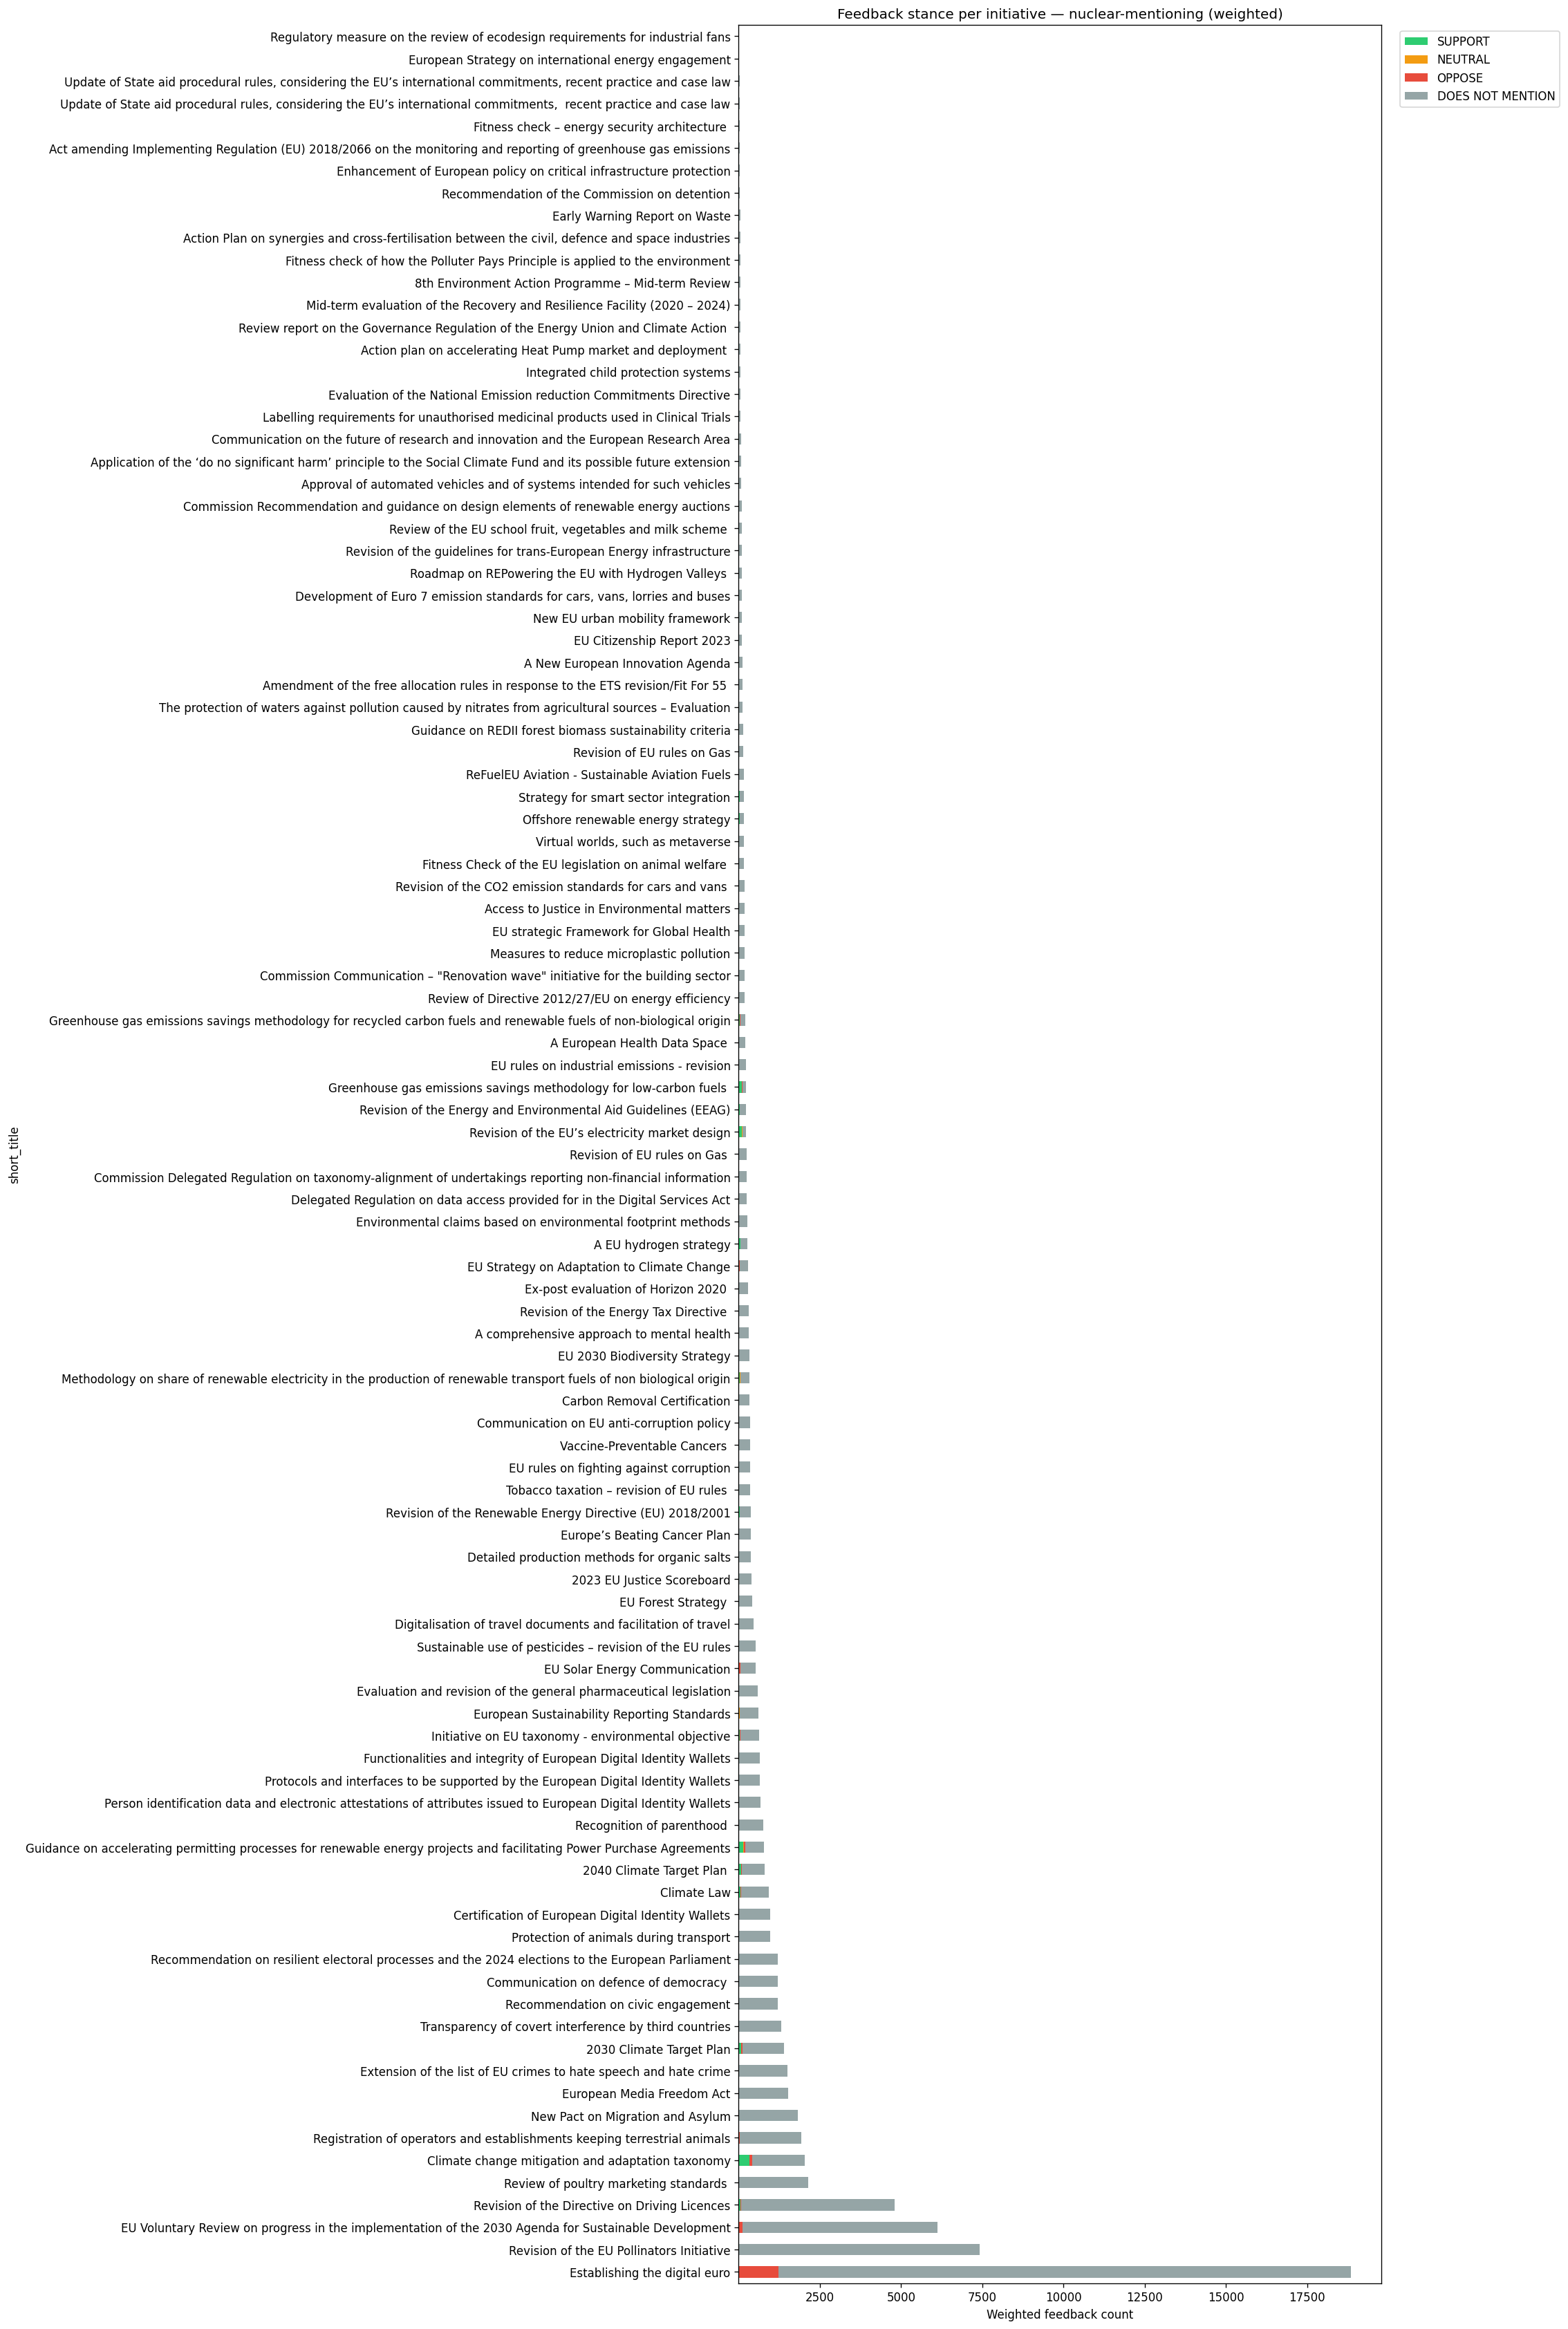

In [11]:
if len(df_fb):
    ct = df_fb.groupby("short_title")[fb_frac_cols].sum()
    ct.columns = LABEL_ORDER
    # Only show initiatives with weighted nuclear-mentioning feedback > 0.5
    mentions = ct.drop(columns="DOES NOT MENTION", errors="ignore").sum(axis=1)
    ct_show = ct[mentions > 0.5].copy()
    ct_show = ct_show.loc[ct_show.sum(axis=1).sort_values(ascending=False).index]

    if len(ct_show):
        fig, ax = plt.subplots(figsize=(10, max(4, len(ct_show) * 0.35)))
        ct_show.plot.barh(
            stacked=True, ax=ax,
            color=[LABEL_COLORS[l] for l in ct_show.columns],
        )
        ax.set_xlabel("Weighted feedback count")
        ax.set_title("Feedback stance per initiative — nuclear-mentioning (weighted)")
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
        fig.tight_layout()
        plt.show()
    else:
        print("No initiatives have nuclear-mentioning feedback.")

## 8. Complex classification results

In [12]:
has_complex = df_init[df_init["before_complex"].apply(len) > 0].copy()

if len(has_complex):
    # For complex output, each entry is free-form text — display as a table
    rows = []
    for _, r in has_complex.iterrows():
        for phase, col in [("before", "before_complex"), ("after", "after_complex")]:
            for run_idx, text in enumerate(r[col]):
                if text:
                    rows.append({
                        "id": r["id"],
                        "short_title": r["short_title"],
                        "phase": phase,
                        "run": run_idx,
                        "complex_output": text[:300] + ("..." if len(text) > 300 else ""),
                    })
    df_complex = pd.DataFrame(rows)
    print(f"{len(df_complex)} complex classification outputs")
    display(df_complex)
else:
    print("No complex classification results found.")

3776 complex classification outputs


,id,short_title,phase,run,complex_output
0,12096,EU 2030 Biodiversity Strategy,before,0,**Result:** The EU Biodiversity Strategy to 2030 does not mention nuclear energy (or SMRs) in the context of climate...
1,12096,EU 2030 Biodiversity Strategy,before,1,**Result:** The EU Biodiversity Strategy to 2030 initiative does not mention nuclear energy (or SMRs) in any climate...
2,12096,EU 2030 Biodiversity Strategy,before,2,*No classification is made for this initiative because nuclear energy is not mentioned in the context of climate or ...
3,12096,EU 2030 Biodiversity Strategy,before,3,"*No classification – nuclear energy is not mentioned in the initiative, so it does not meet the relevance filter.*"
4,12096,EU 2030 Biodiversity Strategy,before,4,"*No classification – nuclear energy is not mentioned in the initiative, so it is excluded by the relevance filter.*"
...,...,...,...,...,...
3771,14392,Fitness check – energy security architecture,after,11,"initiative_id,Commission_Stance,Legitimacy_Mode,Climate_Recognition_Flag,Consultation_Reference_Flag\nEU_Energy_Secu..."
3772,14392,Fitness check – energy security architecture,after,12,- initiative_id: FITNESS_CHECK_2025 \n- Commission_Stance: 0 \n- Legitimacy_Mode: Technocratic \n- Climate_Recogn...
3773,14392,Fitness check – energy security architecture,after,13,"initiative_id,Commission_Stance,Legitimacy_Mode,Climate_Recognition_Flag,Consultation_Reference_Flag \nFITNESS_CHEC..."
3774,14392,Fitness check – energy security architecture,after,14,**initiative_id:** FITNESS_CHECK_ENERGY_SECURITY_2025 \n**Commission_Stance:** 0 \n**Legitimacy_Mode:** Technocrat...


## 9. Initiatives and feedback by stance transition

For each (before, after) stance pair, shows the initiatives in that group and
their feedback stance breakdown.


  DOES NOT MENTION  -->  DOES NOT MENTION   (67 initiatives)



,id,short_title,n_feedback,policy_areas
0,12096,EU 2030 Biodiversity Strategy,328,Environment
1,12108,Climate Law,931,Climate Action
2,12165,Access to Justice in Environmental matters,175,Environment
3,12199,Methodology on share of renewable electricity in the production of renewable transport fuels of non biological origin,337,Energy
4,12313,"Development of Euro 7 emission standards for cars, vans, lorries and buses",234,Internal Market
...,...,...,...,...
62,14240,Application of the ‘do no significant harm’ principle to the Social Climate Fund and its possible future extension,71,"Better Regulation, Fundamental Rights and Rule Of Law, Policy Coordination, Inter-Institutional Relations"
63,14337,Certification of European Digital Identity Wallets,963,Digital Economy and Society
64,14339,Protocols and interfaces to be supported by the European Digital Identity Wallets,649,Digital Economy and Society
65,14340,Person identification data and electronic attestations of attributes issued to European Digital Identity Wallets,675,Digital Economy and Society


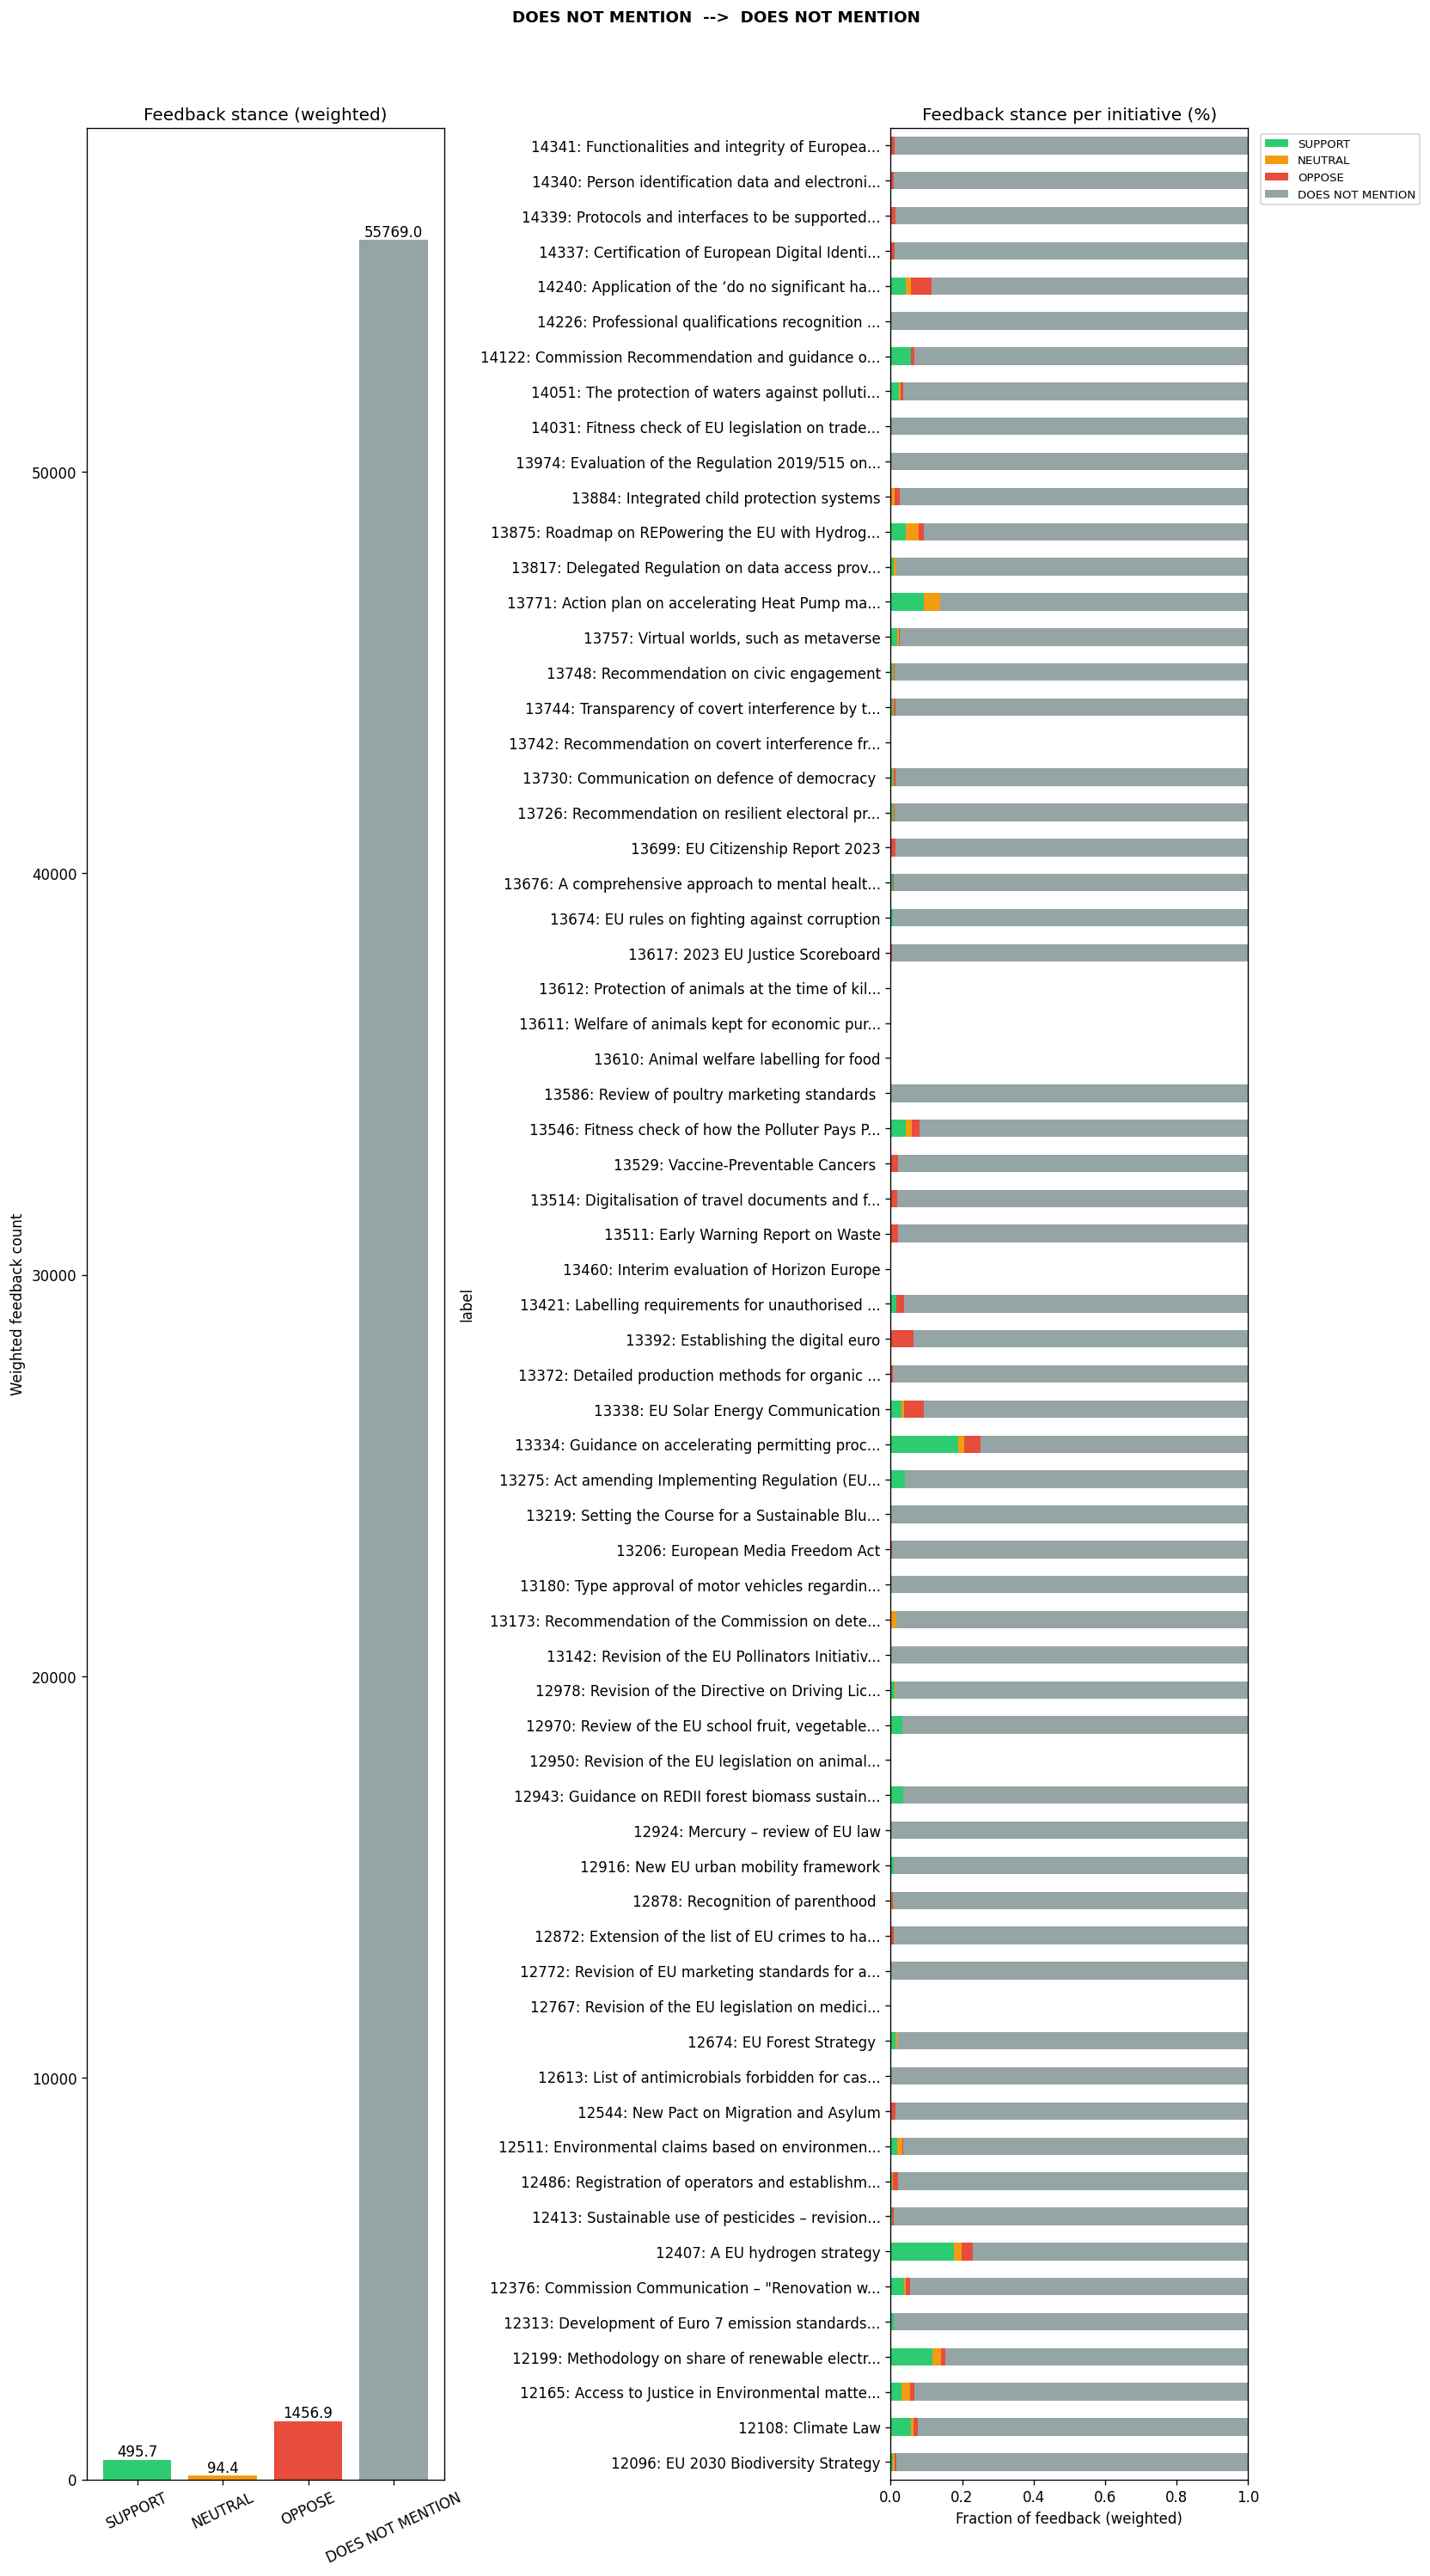


  DOES NOT MENTION  -->  SUPPORT   (31 initiatives)



,id,short_title,n_feedback,policy_areas
0,12154,Europe’s Beating Cancer Plan,2462,Health
1,12265,2030 Climate Target Plan,5125,Climate Action
2,12302,Climate change mitigation and adaptation taxonomy,2040,Financial Services
3,12306,EU rules on industrial emissions - revision,490,Environment
4,12381,EU Strategy on Adaptation to Climate Change,1130,Climate Action
5,12382,Revision of the guidelines for trans-European Energy infrastructure,163,Energy
6,12383,Strategy for smart sector integration,156,Energy
7,12440,Commission Delegated Regulation on taxonomy-alignment of undertakings reporting non-financial information,240,Financial Services
8,12458,Review of the Construction Products Regulation,339,"Industry, Internal Market"
9,12495,Communication on the future of research and innovation and the European Research Area,68,"Research, Science and Innovation"


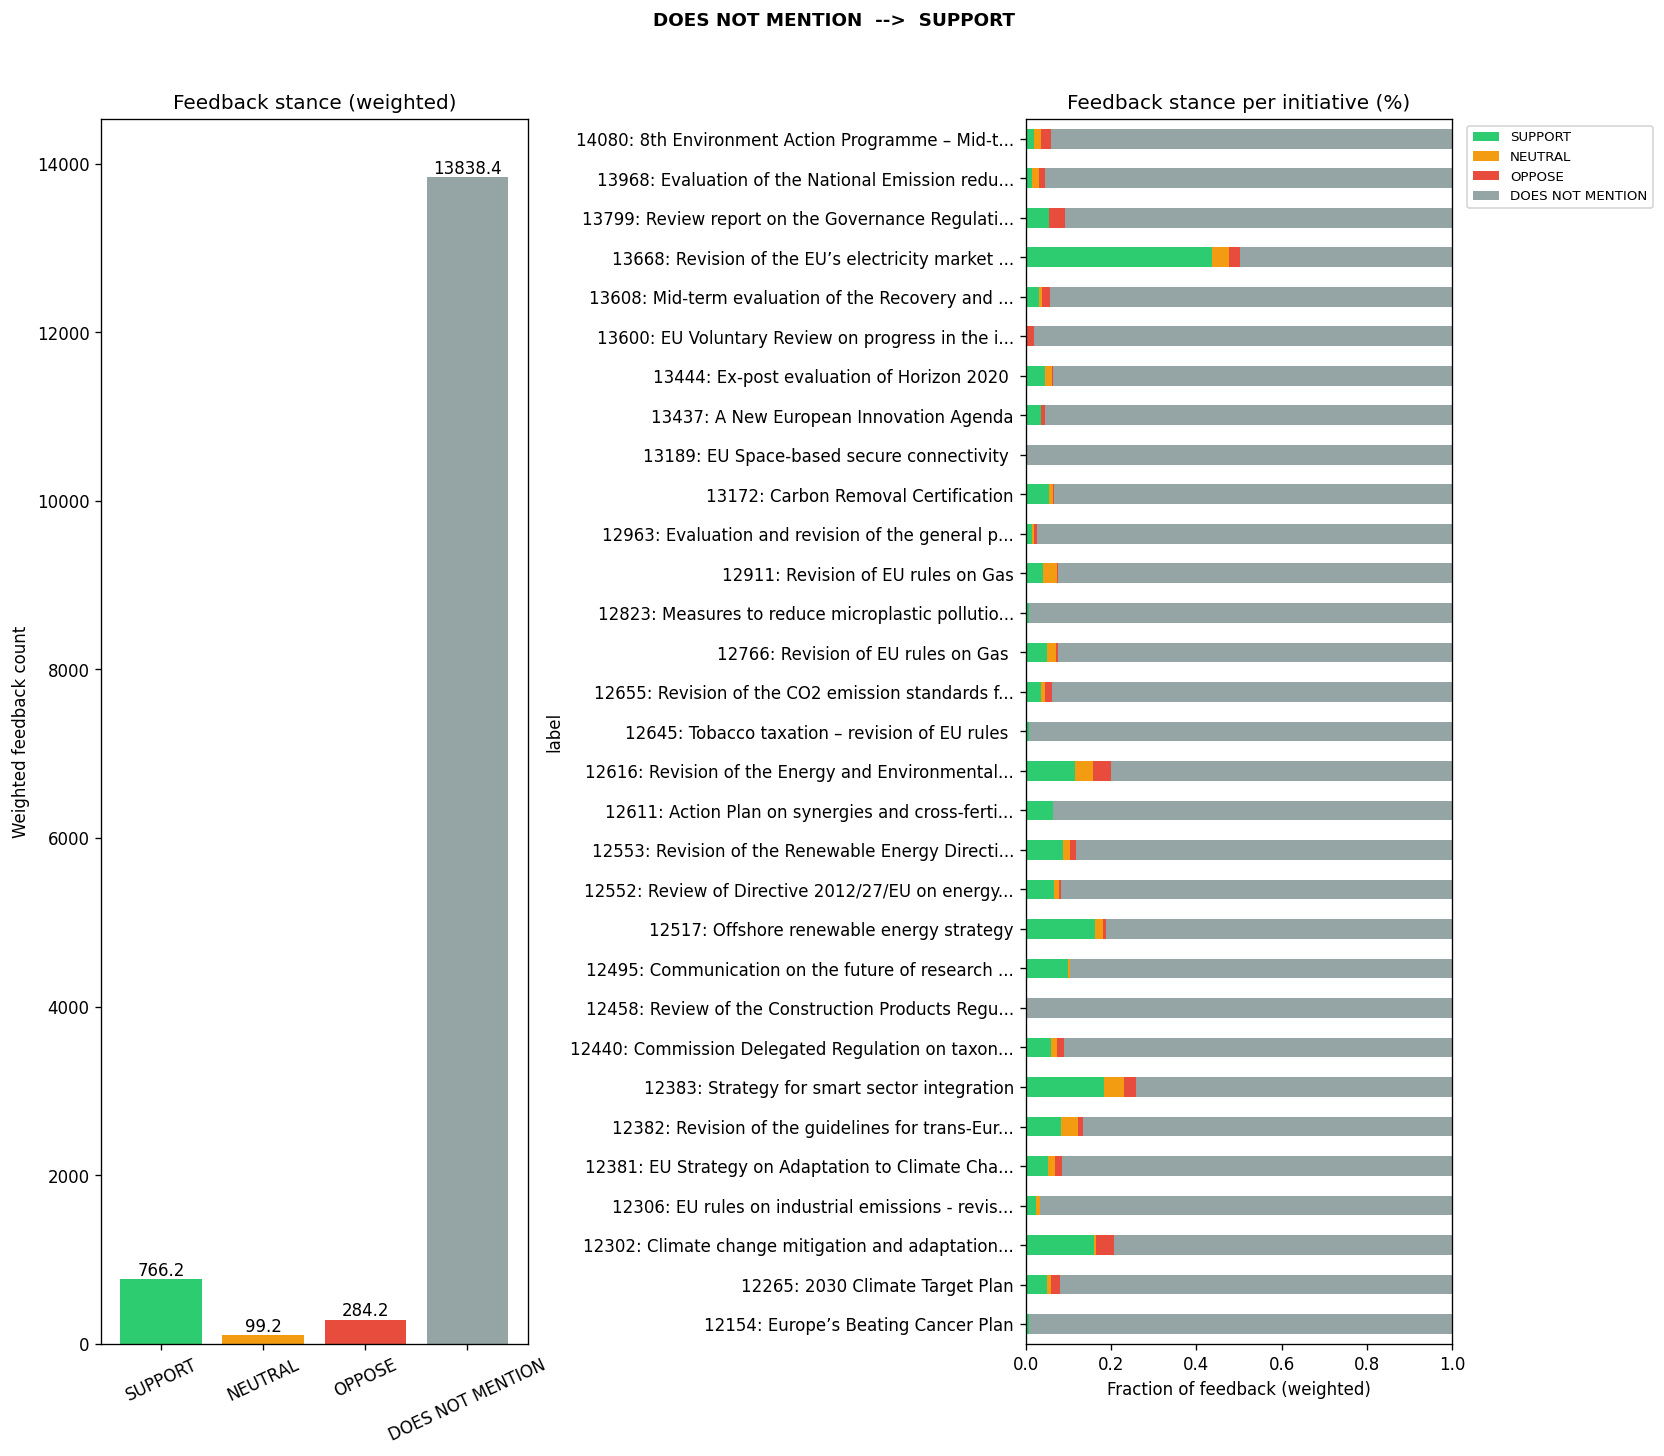


  DOES NOT MENTION  -->  NEUTRAL   (9 initiatives)



,id,short_title,n_feedback,policy_areas
0,12227,Revision of the Energy Tax Directive,743,"Taxation, Climate Action, Energy"
1,12303,ReFuelEU Aviation - Sustainable Aviation Fuels,278,Transport
2,12400,Fitness Check of the EU legislation on animal welfare,58183,Food Safety
3,12663,A European Health Data Space,540,Health
4,13506,EU strategic Framework for Global Health,400,Health
5,13613,Protection of animals during transport,983,Food Safety
6,13677,Communication on EU anti-corruption policy,345,Home Affairs
7,14276,"Update of State aid procedural rules, considering the EU’s international commitments, recent practice and case law",25,Competition
8,14278,"Update of State aid procedural rules, considering the EU’s international commitments, recent practice and case law",25,Competition


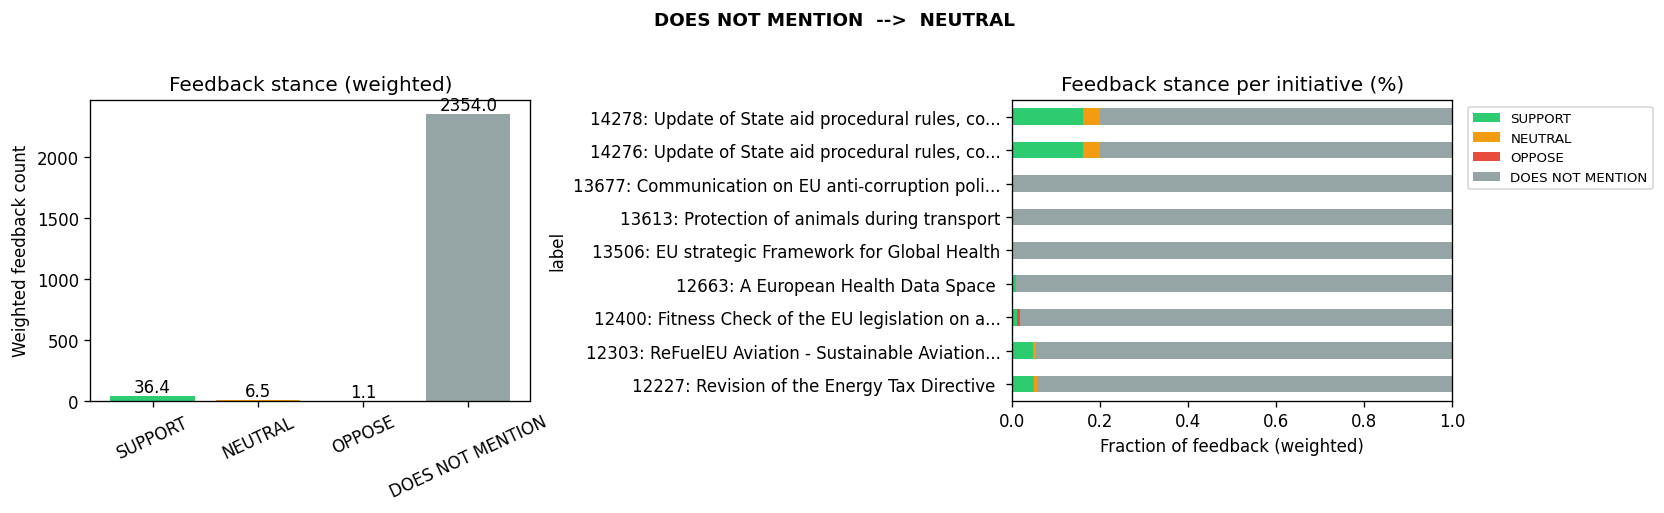


  SUPPORT  -->  SUPPORT   (7 initiatives)



,id,short_title,n_feedback,policy_areas
0,12152,Approval of automated vehicles and of systems intended for such vehicles,78,Internal Market
1,12713,Greenhouse gas emissions savings methodology for recycled carbon fuels and renewable fuels of non-biological origin,199,Energy
2,13276,European Strategy on international energy engagement,18,Energy
3,13793,2040 Climate Target Plan,1486,Climate Action
4,13861,Amendment of the free allocation rules in response to the ETS revision/Fit For 55,123,Climate Action
5,14303,Greenhouse gas emissions savings methodology for low-carbon fuels,228,Energy
6,14392,Fitness check – energy security architecture,113,Energy


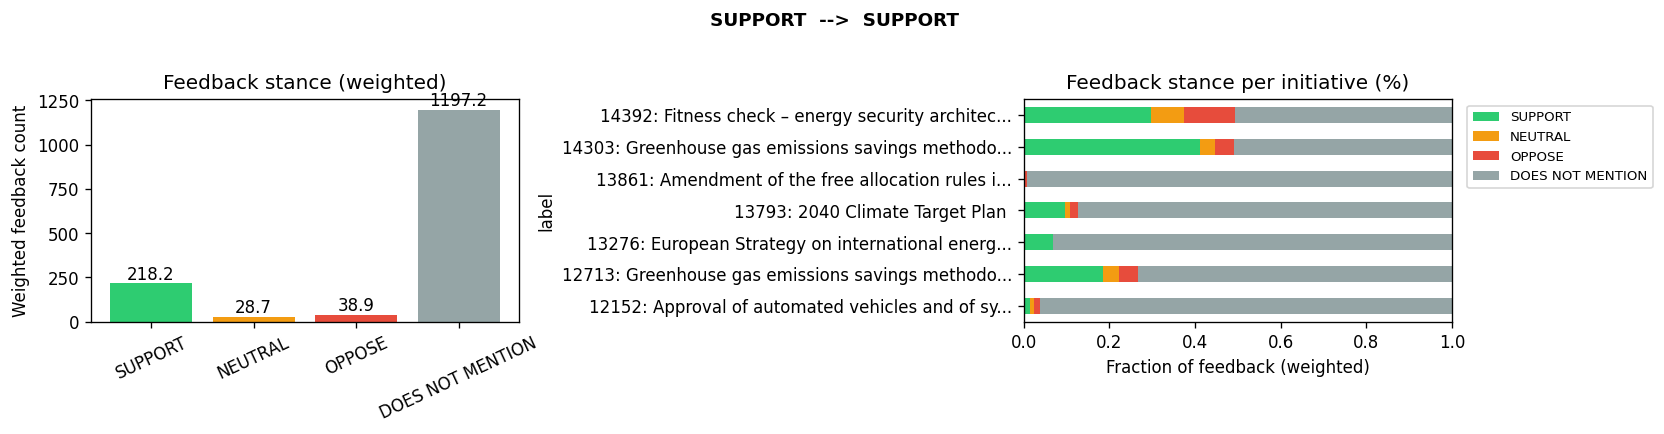


  NEUTRAL  -->  NEUTRAL   (2 initiatives)



,id,short_title,n_feedback,policy_areas
0,12462,Enhancement of European policy on critical infrastructure protection,38,Home Affairs
1,13981,Regulatory measure on the review of ecodesign requirements for industrial fans,17,Energy


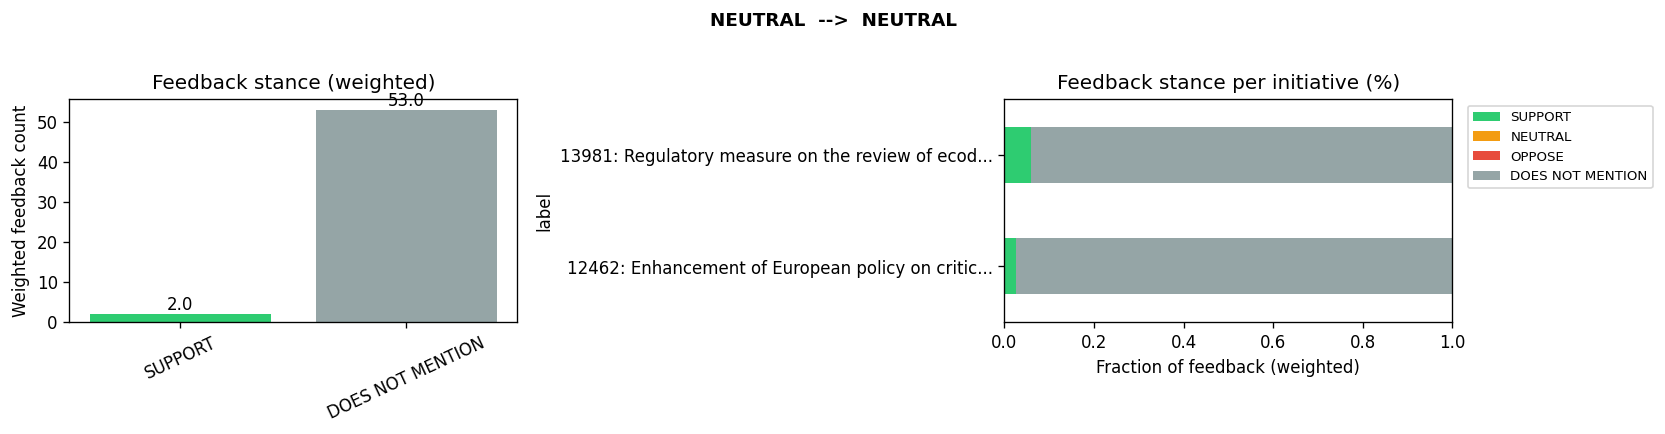


  NEUTRAL  -->  DOES NOT MENTION   (1 initiative)



,id,short_title,n_feedback,policy_areas
0,13765,European Sustainability Reporting Standards,604,"Financial Services, Capital Market Union"


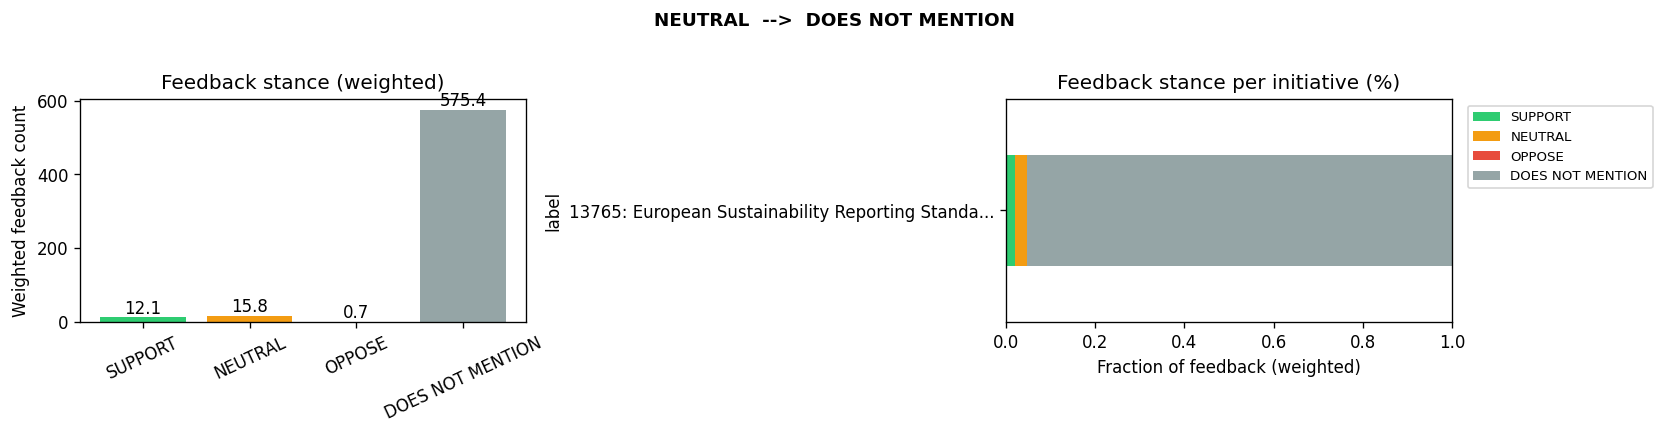


  SUPPORT  -->  DOES NOT MENTION   (1 initiative)



,id,short_title,n_feedback,policy_areas
0,13237,Initiative on EU taxonomy - environmental objective,634,Financial Services


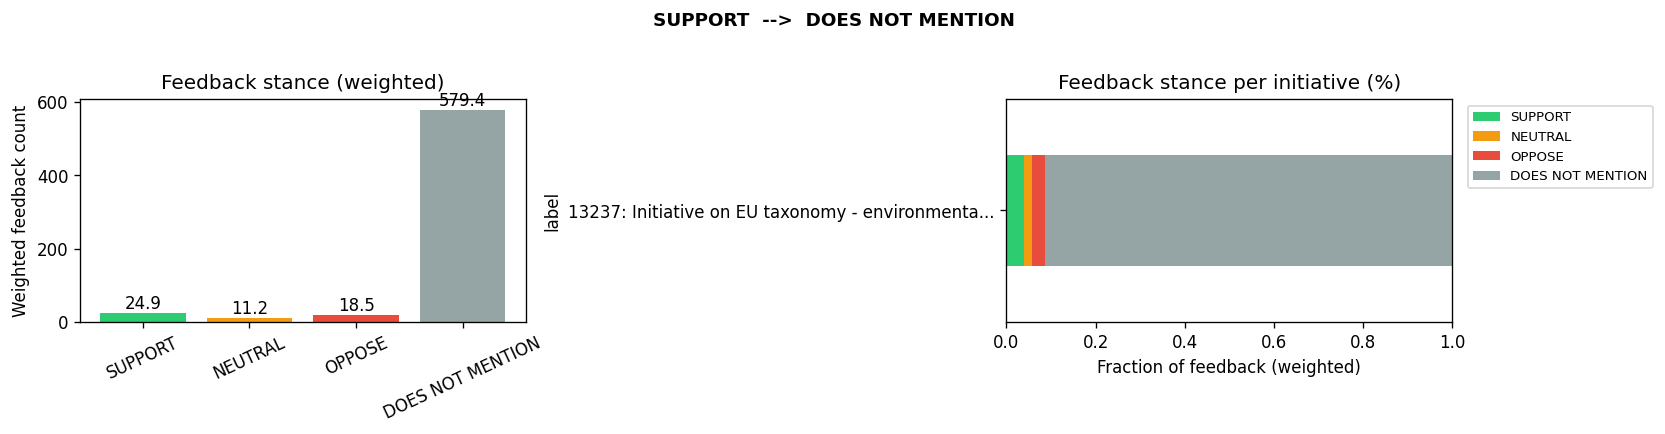

In [13]:
has_both = df_init.dropna(subset=["before_majority", "after_majority"]).copy()

MAX_TITLE_LEN = 40

if not len(has_both):
    print("No initiatives with both before and after classifications.")
else:
    # Build weighted feedback stance per initiative
    fb_weighted_by_init = {}
    if len(df_fb):
        for init_id, grp in df_fb.groupby("initiative_id"):
            fb_weighted_by_init[init_id] = {
                l: grp[f"fb_{l}"].sum() for l in LABEL_ORDER
            }

    def make_chart_label(init_id, title):
        if len(title) > MAX_TITLE_LEN:
            title = title[:MAX_TITLE_LEN] + "..."
        return f"{init_id}: {title}"

    # Iterate over every observed (before, after) transition
    transition_pairs = (
        has_both.groupby(["before_majority", "after_majority"])
        .size()
        .sort_values(ascending=False)
    )

    for (before_label, after_label), count in transition_pairs.items():
        subset = has_both[
            (has_both["before_majority"] == before_label)
            & (has_both["after_majority"] == after_label)
        ].sort_values("id")

        print(f"\n{'='*70}")
        print(f"  {before_label}  -->  {after_label}   ({count} initiative{'s' if count != 1 else ''})")
        print(f"{'='*70}\n")

        # Table of initiatives in this group
        display(
            subset[["id", "short_title", "n_feedback", "policy_areas"]]
            .reset_index(drop=True)
        )

        # Feedback stance breakdown for this group (weighted)
        group_ids = set(subset["id"])
        group_fb_total = {l: 0.0 for l in LABEL_ORDER}
        for iid in group_ids:
            wt = fb_weighted_by_init.get(iid, {})
            for l in LABEL_ORDER:
                group_fb_total[l] += wt.get(l, 0.0)

        if sum(group_fb_total.values()) > 0:
            labels_present = [l for l in LABEL_ORDER if group_fb_total[l] > 0.05]
            vals = [group_fb_total[l] for l in labels_present]
            colors = [LABEL_COLORS[l] for l in labels_present]

            n_inits = len(subset)
            fig, axes = plt.subplots(1, 2, figsize=(14, max(3.5, n_inits * 0.35 + 1)))

            # Bar chart of weighted counts
            bars = axes[0].bar(labels_present, vals, color=colors)
            axes[0].bar_label(bars, fmt="%.1f")
            axes[0].set_ylabel("Weighted feedback count")
            axes[0].set_title("Feedback stance (weighted)")
            axes[0].tick_params(axis="x", rotation=25)

            # Per-initiative stacked bar (% of each initiative's weighted feedback)
            init_rows = []
            for _, r in subset.iterrows():
                wt = fb_weighted_by_init.get(r["id"], {})
                total = sum(wt.get(l, 0.0) for l in LABEL_ORDER) or 1.0
                row = {l: wt.get(l, 0.0) / total for l in LABEL_ORDER}
                row["label"] = make_chart_label(r["id"], r["short_title"])
                init_rows.append(row)
            df_pct = pd.DataFrame(init_rows).set_index("label")
            df_pct = df_pct[LABEL_ORDER]

            df_pct.plot.barh(
                stacked=True, ax=axes[1],
                color=[LABEL_COLORS[l] for l in LABEL_ORDER],
                legend=False,
            )
            axes[1].set_xlabel("Fraction of feedback (weighted)")
            axes[1].set_title("Feedback stance per initiative (%)")
            axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
            axes[1].set_xlim(0, 1)

            fig.suptitle(
                f"{before_label}  -->  {after_label}",
                fontsize=11, fontweight="bold", y=1.02,
            )
            fig.tight_layout()
            plt.show()
        else:
            print("  (no feedback for initiatives in this group)")